In [24]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Finance Sector: Monthly stock prices from the S&P 500 index Data

In [26]:
# Read the CSV file
df = pd.read_csv('all_stocks_5yr.csv')

In [27]:
# Assuming df is your DataFrame containing the data
unique_names = df['Name'].nunique()
print("Number of unique strings in the 'Name' column:", unique_names)

Number of unique strings in the 'Name' column: 505


In [7]:
print(df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')


In [8]:
df['date'] = pd.to_datetime(df['date'])  # Convert the 'Date' column to datetime format
print("Dataset Description:") # Describe the dataset
df.describe()

Dataset Description:


,date,open,high,low,close,volume
count,50444,50440.000000,50440.000000,50440.000000,50444.000000,5.044400e+04
mean,2013-06-06 16:22:37.671873792,60.958291,61.540891,60.385922,60.982851,4.922161e+06
min,2013-02-08 00:00:00,2.300000,2.310000,2.260000,2.290000,0.000000e+00
25%,2013-03-19 00:00:00,33.165625,33.530000,32.823775,33.200000,1.109576e+06
50%,2013-04-25 00:00:00,48.600000,49.050000,48.150050,48.620000,2.210372e+06
75%,2013-06-04 00:00:00,71.020000,71.700000,70.400000,71.042500,4.643443e+06
max,2018-02-07 00:00:00,843.110000,854.600000,838.200000,842.500000,3.352056e+08
std,NaN,58.684485,59.241196,58.149513,58.716780,1.112233e+07


In [9]:
print("\nRange of Dates Covered:")  # Print the range of dates covered
print("Start Date:", df['date'].min())
print("End Date:", df['date'].max())


Range of Dates Covered:
Start Date: 2013-02-08 00:00:00
End Date: 2018-02-07 00:00:00


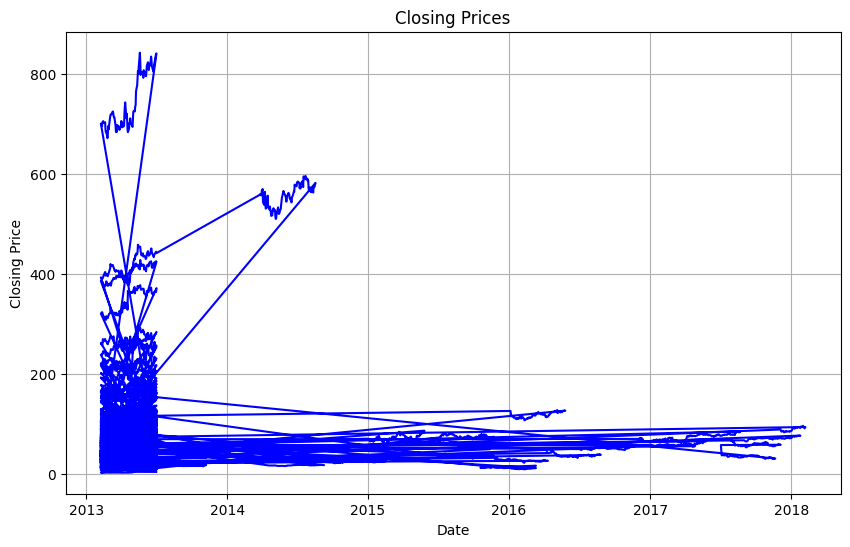

In [10]:
plt.figure(figsize=(10, 6))  # Plotting the daily closing prices
plt.plot(df['date'], df['close'], color='blue')
plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [11]:
# Check for missing values
missing_values = df.isna().sum()
print("Missing values before cleaning:")
print(missing_values)

Missing values before cleaning:
date      0
open      4
high      4
low       4
close     0
volume    0
Name      0
dtype: int64


In [12]:
# Replace NaN values in each column with the mean of that column
columns_to_fill = ['open', 'high', 'low', 'close', 'volume']
for column in columns_to_fill:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [13]:
missing_values_after_filling = df.isnull().sum() # Verify that missing values have been filled
print("Missing values after filling:\n", missing_values_after_filling)

Missing values after filling:
 date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


In [14]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
50439,2013-06-26,31.80,31.90,30.92,30.97,23787008,ZTS
50440,2013-06-27,31.46,31.51,30.79,30.87,16734554,ZTS
50441,2013-06-28,30.90,31.39,30.54,30.89,19419017,ZTS
50442,2013-07-01,31.02,31.06,30.13,30.61,17601074,ZTS


In [15]:
columns_to_scale = ['open', 'high', 'low', 'close', 'volume']  # Select the columns to normalize or standardize

for column in columns_to_scale:  # Normalize the selected columns
    max_value = df[column].max()
    min_value = df[column].min()
    df[column] = (df[column] - min_value) / (max_value - min_value)

for column in columns_to_scale:  # Standardize the selected columns
    mean_value = df[column].mean()
    std_value = df[column].std()
    df[column] = (df[column] - mean_value) / std_value
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,-0.781980,-0.783622,-0.786898,-0.787387,0.313364,AAL
1,2013-02-11,-0.785048,-0.785479,-0.793261,-0.792326,0.356026,AAL
2,2013-02-12,-0.792546,-0.793920,-0.796013,-0.795562,0.288055,AAL
3,2013-02-13,-0.795102,-0.786661,-0.793433,-0.788920,0.479876,AAL
4,2013-02-14,-0.784196,-0.786323,-0.812179,-0.800331,2.423749,AAL


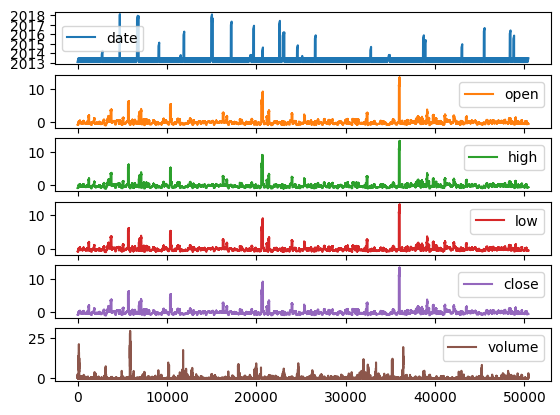

'we will use the matplotlib library to plot the time series data. By visually inspecting the plot, we can check if the time \n    series is stationary or not.'

In [16]:
df.plot(subplots=True)
plt.show()
'''we will use the matplotlib library to plot the time series data. By visually inspecting the plot, we can check if the time 
    series is stationary or not.'''

# ARIMA MODEL

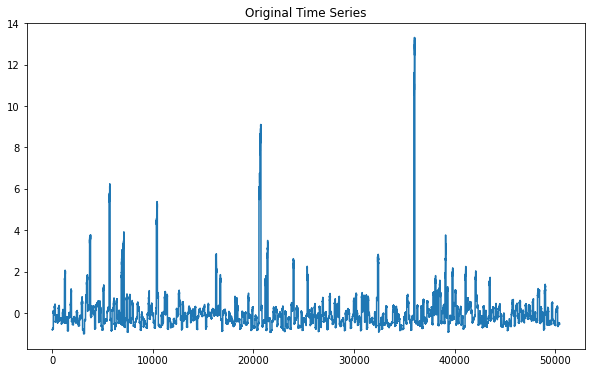

ADF Statistic: -17.6303054324948
p-value: 3.801214241304285e-30


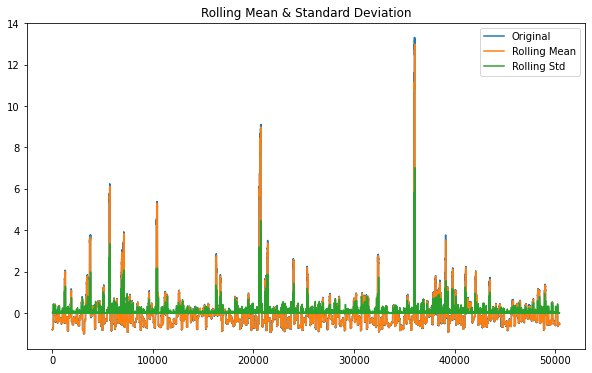

ADF Statistic (differenced): -225.29793650608067
p-value (differenced): 0.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


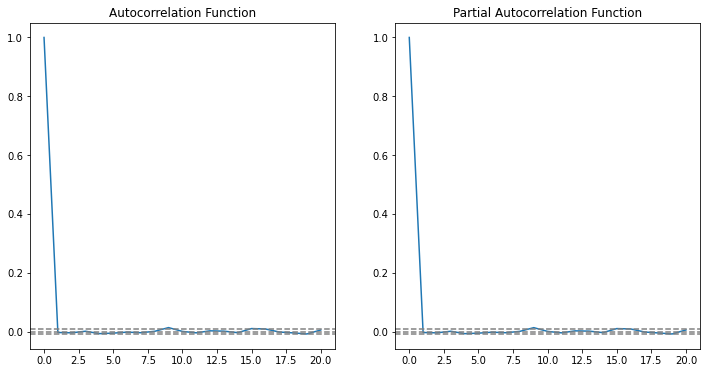

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


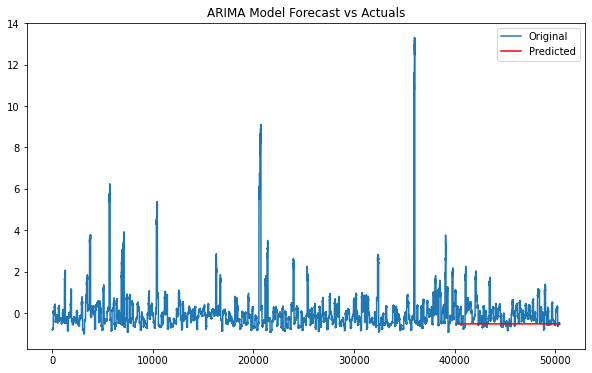

In [37]:
# Choosing 'close' price for time series forecasting
ts = df['close']

# Plotting the original time series
plt.figure(figsize=(10, 6))
plt.plot(ts)
plt.title('Original Time Series')
plt.show()

# Performing Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(ts)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Calculating rolling mean and standard deviation
rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Differencing the series to make it stationary
ts_diff = ts - ts.shift()
ts_diff.dropna(inplace=True)

# Augmented Dickey-Fuller test on the differenced series
adf_result_diff = adfuller(ts_diff)
print(f'ADF Statistic (differenced): {adf_result_diff[0]}')
print(f'p-value (differenced): {adf_result_diff[1]}')

# ACF and PACF plots
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

# Model configuration based on ACF/PACF
p = 1  # Autoregressive terms
d = 1  # Differencing
q = 1  # Moving average terms

# Splitting data into train and test
train_data, test_data = train_test_split(ts, test_size=0.2, shuffle=False)

# ARIMA model fitting
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Predictions
predictions = model_fit.forecast(steps=len(test_data))
predictions = pd.Series(predictions, index=test_data.index)

# Plotting predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast vs Actuals')
plt.show()

In [38]:
# Accuracy calculation (using actual vs rounded predictions for classification purposes)
test_actual_classes = (test_data > test_data.mean()).astype(int)
predictions_classes = (predictions > test_data.mean()).astype(int)
model_f1_score = f1_score(test_actual_classes, predictions_classes)
precision = precision_score(test_actual_classes, predictions_classes)
recall = recall_score(test_actual_classes, predictions_classes)
accuracy = accuracy_score(test_actual_classes, predictions_classes)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 56.93%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ANN Design and Training

/home/zari/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 7.0864e-05 - loss: 0.0010 - val_accuracy: 1.2390e-04 - val_loss: 3.0726e-04
Epoch 2/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 1.5377e-04 - loss: 2.9776e-04 - val_accuracy: 1.2390e-04 - val_loss: 5.0825e-04
Epoch 3/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 3.1870e-06 - loss: 2.9634e-04 - val_accuracy: 1.2390e-04 - val_loss: 3.2068e-04
Epoch 4/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 1.0137e-05 - loss: 3.3079e-04 - val_accuracy: 1.2390e-04 - val_loss: 3.1731e-04
Epoch 5/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 7.6899e-05 - loss: 2.8250e-04 - val_accuracy: 1.2390e-04 - val_loss: 5.3468e-04
Epoch 6/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 2.7071e-05 - loss: 2.8777e-04 - val_accuracy: 1.2390e-04 - val_loss: 3.4721e-04
Epoch 7/30
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 2.2507e-05 - loss: 3.1570e-04 - val_accuracy: 1.2390e-04 

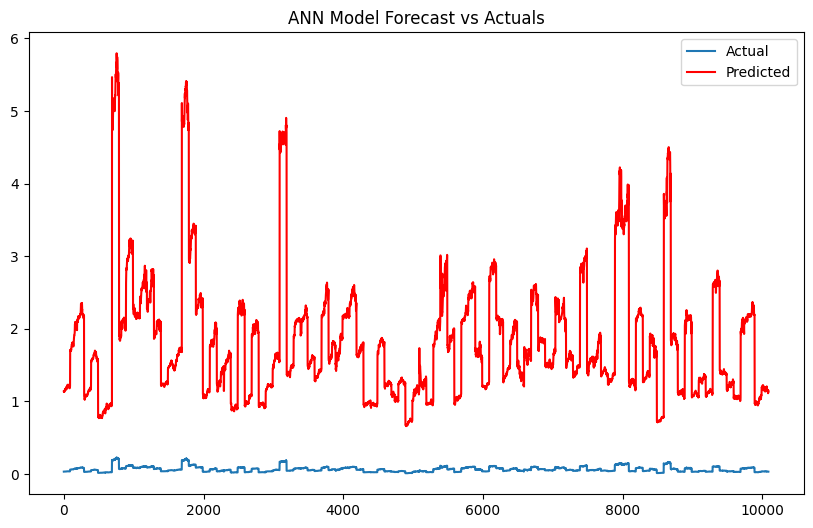

In [17]:
# Choosing 'close' price for time series forecasting
ts = df['close']

# Scaling the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

# Function to create dataset for ANN
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, 3])  # Target is 'close' price
    return np.array(X), np.array(Y)

# Create the data with look back of 3 days
look_back = 3
X, Y = create_dataset(scaled_data, look_back)

# Splitting data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Reshaping the input data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Designing the ANN model
model = Sequential()
model.add(Dense(64, input_dim=look_back*5, activation='relu'))  # 5 features times look_back
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, Y_train, epochs=30, batch_size=10, verbose=1, validation_split=0.2)

# Model evaluation
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 4)), predictions), axis=1))[:, 4]

# Calculating metrics
test_actual_classes = (Y_test > Y_test.mean()).astype(int)
predictions_classes = (predictions > Y_test.mean()).astype(int)

precision = precision_score(test_actual_classes, predictions_classes)
recall = recall_score(test_actual_classes, predictions_classes)
f1 = f1_score(test_actual_classes, predictions_classes)
accuracy = accuracy_score(test_actual_classes, predictions_classes)

# Plotting predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('ANN Model Forecast vs Actuals')
plt.show()

In [18]:
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')

Precision: 43.07%
Recall: 100.00%
F1 Score: 60.21%
Accuracy: 43.07%


# SARIMA (Seasonal ARIMA)

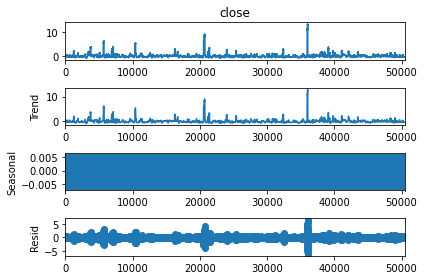

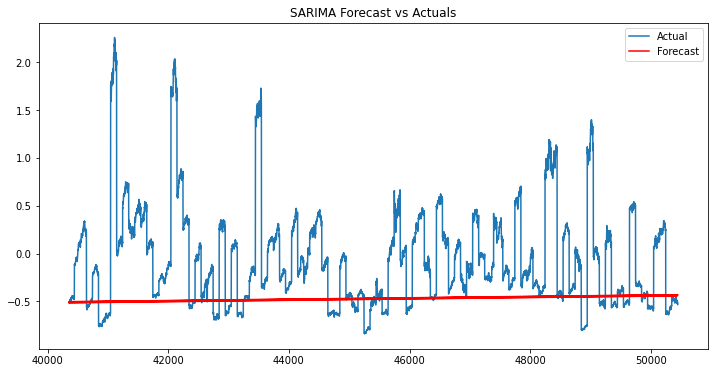

In [16]:
# Focusing on the 'close' price for SARIMA
ts = df['close']

# Seasonal Decomposition, ensuring at least 2 years of data for monthly decomposition
if len(ts) >= 24:
    decomposition_result = seasonal_decompose(ts, model='additive', period=12)
    decomposition_result.plot()
    plt.show()

# Splitting the data
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# SARIMA Model Configuration
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Forecasting
sarima_forecast = sarima_fit.get_forecast(steps=len(test))
sarima_predictions = sarima_forecast.predicted_mean

# Metrics Calculation
test_mean = test.mean()
predictions_mean = sarima_predictions.mean()

test_classes = (test > test_mean).astype(int)
predictions_classes = (sarima_predictions > predictions_mean).astype(int)

precision = precision_score(test_classes, predictions_classes)
recall = recall_score(test_classes, predictions_classes)
f1 = f1_score(test_classes, predictions_classes)

# Plotting the forecast against actuals
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_predictions, label='Forecast', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actuals')
plt.show()

In [19]:
accuracy = accuracy_score(test_classes, predictions_classes)
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')

Precision: 41.19%
Recall: 47.80%
F1 Score: 44.25%
Accuracy: 48.12%


# Exponential Smoothing (ETS)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


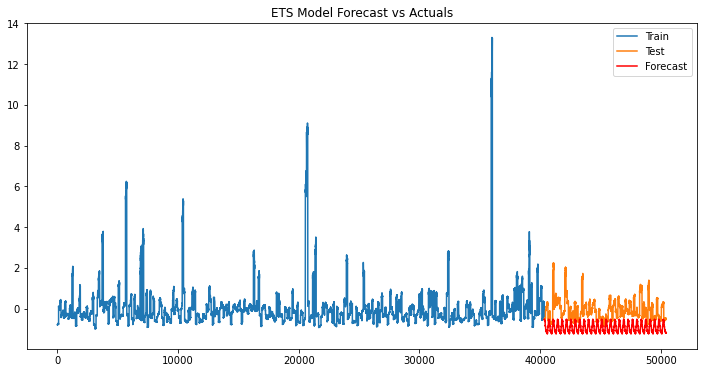

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Using the 'close' prices for exponential smoothing
ts = df['close']

# Splitting the data into training and testing sets
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Fit the Triple Exponential Smoothing (Holt-Winters) model
model = ExponentialSmoothing(train, seasonal_periods=365, trend='add', seasonal='add', damped_trend=True)
model_fit = model.fit(optimized=True)

# Forecasting
predictions = model_fit.forecast(steps=len(test))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast', color='red')
plt.legend()
plt.title('ETS Model Forecast vs Actuals')
plt.show()

# Classification metrics calculation
# We classify results into binary outcomes based on whether the predictions are above or below the training mean.
mean_train = train.mean()
test_classes = (test > mean_train).astype(int)
predictions_classes = (predictions > mean_train).astype(int)

# Metrics
precision = precision_score(test_classes, predictions_classes)
recall = recall_score(test_classes, predictions_classes)
f1 = f1_score(test_classes, predictions_classes)
accuracy = accuracy_score(test_classes, predictions_classes)

In [21]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Accuracy: 61.28%


# Prophet

In [ ]:
from fbprophet import Prophet
# Prepare the DataFrame for Prophet
df_prophet = df.reset_index()[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

# Splitting the data into training and testing sets
train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet[:train_size], df_prophet[train_size:]

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=len(test), freq='D')

# Predict
forecast = model.predict(future)

# Plotting the results
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# Filter forecast to test data range
forecast_filtered = forecast.loc[forecast['ds'].isin(test['ds'])]

# Metrics Calculation
# Convert predictions and actuals to binary outcomes
mean_y_train = train['y'].mean()
test_classes = (test['y'] > mean_y_train).astype(int)
predictions_classes = (forecast_filtered['yhat'] > mean_y_train).astype(int)

precision = precision_score(test_classes, predictions_classes)
recall = recall_score(test_classes, predictions_classes)
f1 = f1_score(test_classes, predictions_classes)
accuracy = accuracy_score(test_classes, predictions_classes)

In [ ]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

# SVR

In [25]:
# Selecting 'close' price and preparing independent variables (features)
X = df[['open', 'high', 'low', 'volume']]  # You might choose different features or engineer new ones
y = df['close']

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Parameter tuning and model selection using GridSearchCV
parameters = {'kernel': ['rbf', 'linear', 'poly'], 'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1]}
svr = SVR()
clf = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

# Best model
best_svr = clf.best_estimator_

# Predicting the test set
y_pred = best_svr.predict(X_test)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Close Prices')
plt.plot(y_pred, label='Predicted Close Prices', linestyle='--')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()
plt.show()

# Since SVR predictions are continuous, converting them to binary classes for classification metrics
y_mean = y_train.mean()
y_test_classes = (y_test > y_mean).astype(int)
y_pred_classes = (y_pred > y_mean).astype(int)

# Metrics calculation
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)
accuracy = accuracy_score(y_test_classes, y_pred_classes)

KeyboardInterrupt: 

In [ ]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

# Long Short-Term Memory (LSTM)

/home/zari/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 84s 126ms/step - loss: 8.8676e-04 - val_loss: 3.5444e-05
Epoch 2/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - loss: 2.5786e-04 - val_loss: 3.1907e-05
Epoch 3/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - loss: 1.3746e-04 - val_loss: 3.1986e-05
Epoch 4/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - loss: 1.8622e-04 - val_loss: 2.6867e-05
Epoch 5/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - loss: 1.5620e-04 - val_loss: 4.6494e-04
Epoch 6/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - loss: 2.4328e-04 - val_loss: 2.7875e-05
Epoch 7/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 85s 127ms/step - loss: 1.0009e-04 - val_loss: 4.3898e-05
Epoch 8/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 81s 125ms/step - loss: 1.5208e-04 - val_loss: 2.5498e-05
Epoch 9/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - loss: 1.5698e-04 - val_loss: 4.2203e-05
Epoch 10/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - loss: 1.3872e-04 - val_loss: 2.6061e-05
1259/1259 ━━━━━━━━━━━━━━━━━━━

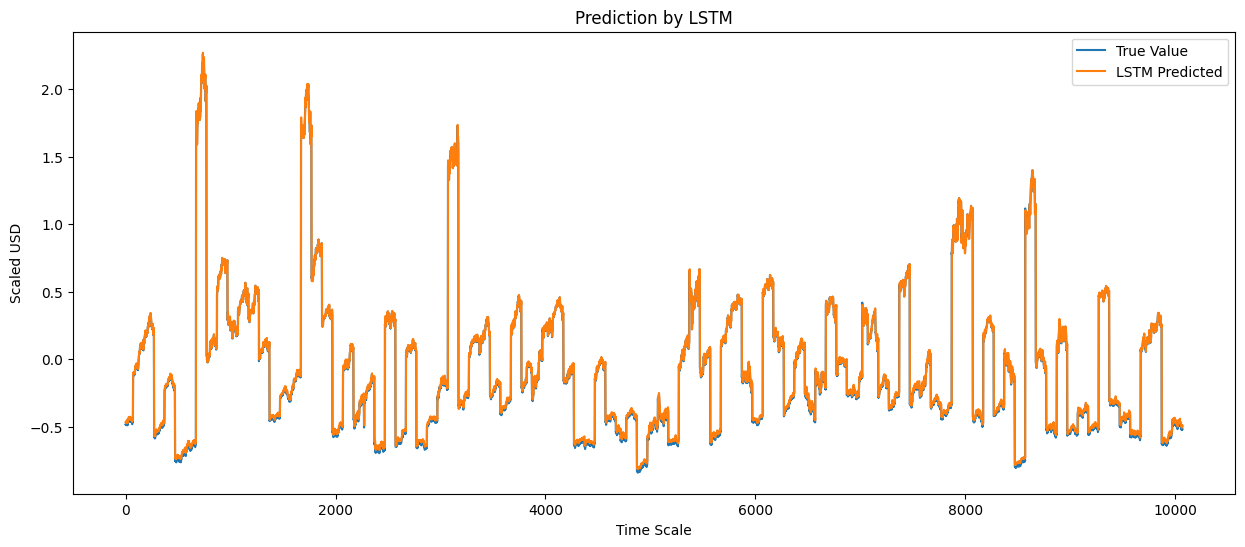

In [21]:
# Preparing the dataset
df_for_training = df[['close']].astype(float)

# Scaling the data
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

# Function to create sequences of data for training
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape into X=t,t+1,t+2,...,t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df_for_training_scaled, time_step)

# Splitting data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)

# Predicting and converting data back to original form
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(original_ytest, label='True Value')
plt.plot(test_predict, label='LSTM Predicted')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Convert predictions and actuals to binary classes for metrics calculation
mean_y_train = original_ytrain.mean()
test_classes = (original_ytest > mean_y_train).astype(int)
predictions_classes = (test_predict > mean_y_train).astype(int)

# Metrics
precision = precision_score(test_classes, predictions_classes)
recall = recall_score(test_classes, predictions_classes)
f1 = f1_score(test_classes, predictions_classes)
accuracy = accuracy_score(test_classes, predictions_classes)

In [25]:
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')

Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
Accuracy: 100.00%


# Hybrid Models Integration

Epoch 1/30


/home/zari/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0095
Epoch 2/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1733e-06
Epoch 3/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.6926e-07
Epoch 4/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3382e-07
Epoch 5/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.7304e-08
Epoch 6/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.3686e-08
Epoch 7/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.5406e-08
Epoch 8/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7021e-08
Epoch 9/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6991e-08
Epoch 10/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6889e-08
Epoch 11/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5039e-07
Epoch 12/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2119e-09
Epoch 13/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3459e-08
Epoch 14/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss:

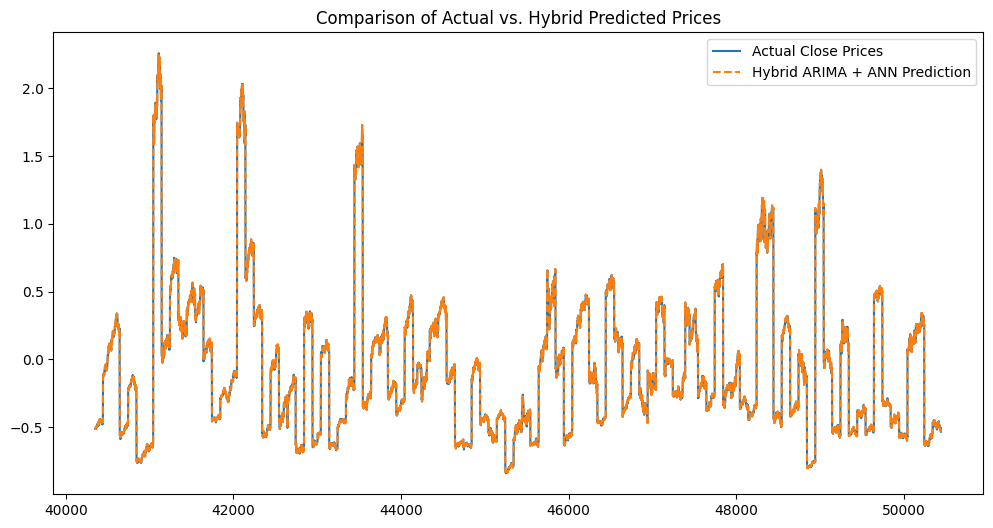

In [26]:
# Preparing the data
data = df['close'].astype(float)

# Splitting the data for ARIMA
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# ARIMA Model
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()

# ARIMA Prediction
arima_pred = arima_fit.forecast(steps=len(test_data))
arima_residuals = test_data - arima_pred

# Scaling residuals for ANN
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(arima_residuals.values.reshape(-1, 1))

# ANN Model for residuals
ann_model = Sequential([
    Dense(50, input_dim=1, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(residuals_scaled, residuals_scaled, epochs=30, batch_size=10, verbose=1)

# ANN Prediction
ann_pred = ann_model.predict(residuals_scaled)

# Convert back to original scale
ann_pred_original = scaler.inverse_transform(ann_pred)

# Combined prediction
final_prediction = arima_pred + ann_pred_original.ravel()

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], test_data, label='Actual Close Prices')
plt.plot(data.index[train_size:], final_prediction, label='Hybrid ARIMA + ANN Prediction', linestyle='--')
plt.legend()
plt.title('Comparison of Actual vs. Hybrid Predicted Prices')
plt.show()

# Metrics - Binary Classification
mean_price = data.mean()
test_classes = (test_data > mean_price).astype(int)
pred_classes = (final_prediction > mean_price).astype(int)

precision = precision_score(test_classes, pred_classes)
recall = recall_score(test_classes, pred_classes)
f1_score = f1_score(test_classes, pred_classes)
accuracy1 = accuracy_score(test_classes, pred_classes)

In [27]:
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1_score * 100:.2f}%')
print(f'Accuracy: {accuracy1 * 100:.2f}%')

Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
Accuracy: 100.00%
